In [24]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

from utils.load_data import load_distributional_dataset
from models.flow_forward import FlowForwardModel
from config import DISTRIBUTIONAL_DATA_PATH

# === setup ===
trial = 1
model_type = "flow"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === paths ===
base_dir = f"checkpoints/{model_type}/{model_type}_trial_{trial}"
config_path = f"{base_dir}/config_{trial}.txt"
model_path = f"{base_dir}/{model_type}_ckpt_{trial}.pt"

# === load config from file ===
with open(config_path, "r") as f:
    lines = f.readlines()
config_dict = {
    line.split(":")[0].strip(): eval(line.split(":")[1].strip())
    for line in lines if ":" in line
}

# === extract config values ===
S_DIM = config_dict["S_DIM"]
P_DIM = config_dict["P_DIM"]
HIDDEN_DIMS = config_dict["HIDDEN_DIMS"]
NUM_FLOWS = config_dict["NUM_FLOWS"]

# === load model ===
model = FlowForwardModel(S_DIM, P_DIM, hidden_dims=HIDDEN_DIMS, num_flows=NUM_FLOWS).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("✅ Loaded flow forward model from trial", trial)

# === print config ===
print("✅ Config for trial", trial)
for k, v in config_dict.items():
    print(f"   - {k}: {v}")

✅ Loaded flow forward model from trial 1
✅ Config for trial 1
   - S_DIM: 4
   - P_DIM: 9
   - HIDDEN_DIMS: [128, 64, 32]
   - NUM_FLOWS: 3
   - BATCH_SIZE: 64
   - LEARNING_RATE: 0.001
   - NUM_EPOCHS: 500
   - BETA_VAR_REG: 0.01


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_160/2697334952.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, m

In [25]:
# === load empirical distributional dataset ===
empirical_data = load_distributional_dataset(DISTRIBUTIONAL_DATA_PATH)
S_keys = list(empirical_data.keys())
print(f"✅ Loaded {len(S_keys)} unique S values.")

# === pick a structure S to analyze ===
S_val = np.array(S_keys[0])  # change index here to test others
P_true_samples = empirical_data[S_keys[0]]
print(f"✅ Empirical P samples for S={S_val}: shape {P_true_samples.shape}")

# === convert S to torch tensor ===
S_val_torch = torch.tensor(S_val, dtype=torch.float32).unsqueeze(0).to(device)

✅ Loaded 30 unique S values.
✅ Empirical P samples for S=[39.383007  34.080853   0.         0.6440046]: shape (100, 9)


In [26]:
# === prediction and sampling function ===
def get_P_predictions(S_val_torch, num_samples=100):
    S_tensor = S_val_torch.repeat(num_samples, 1).to(device)
    with torch.no_grad():
        z_k, _, mu, log_sigma = model(S_tensor)
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(mu)
        P_samples = mu + sigma * eps
    return mu[0].cpu().numpy(), sigma[0].cpu().numpy(), P_samples.cpu().numpy()

# === run prediction ===
mu_pred, sigma_pred, P_hats = get_P_predictions(S_val_torch, num_samples=100)

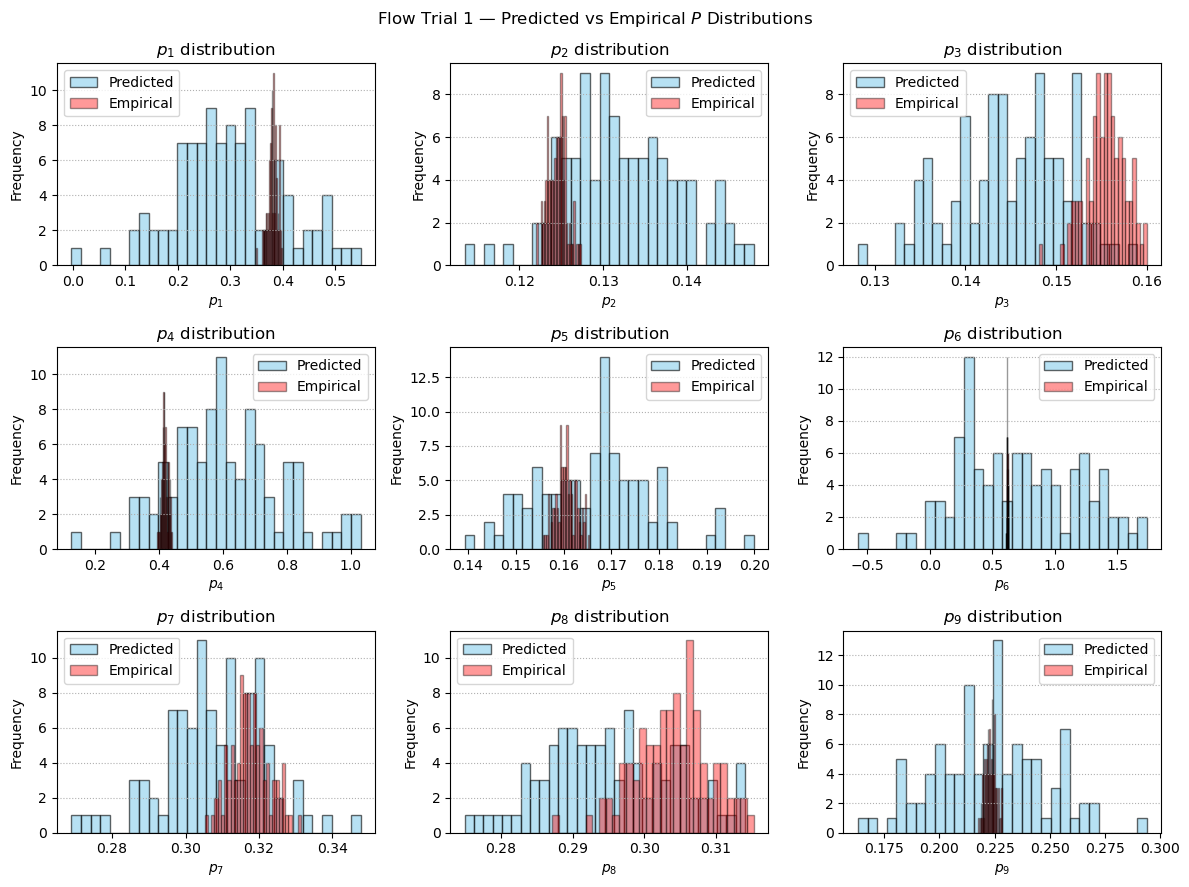

In [27]:
# === histogram plots ===
fig, axs = plt.subplots(3, 3, figsize=(12, 9))
axs = axs.flatten()
for i in range(9):
    axs[i].hist(P_hats[:, i], bins=30, color='skyblue', alpha=0.6, edgecolor='black', label='Predicted')
    axs[i].hist(P_true_samples[:, i], bins=30, color='red', alpha=0.4, edgecolor='black', label='Empirical')
    axs[i].set_title(f"$p_{{{i+1}}}$ distribution")
    axs[i].set_xlabel(f"$p_{{{i+1}}}$")
    axs[i].set_ylabel("Frequency")
    axs[i].legend()
    axs[i].grid(True, linestyle=':', axis='y')
plt.suptitle(f"Flow Trial {trial} — Predicted vs Empirical $P$ Distributions")
plt.tight_layout()
plt.show()

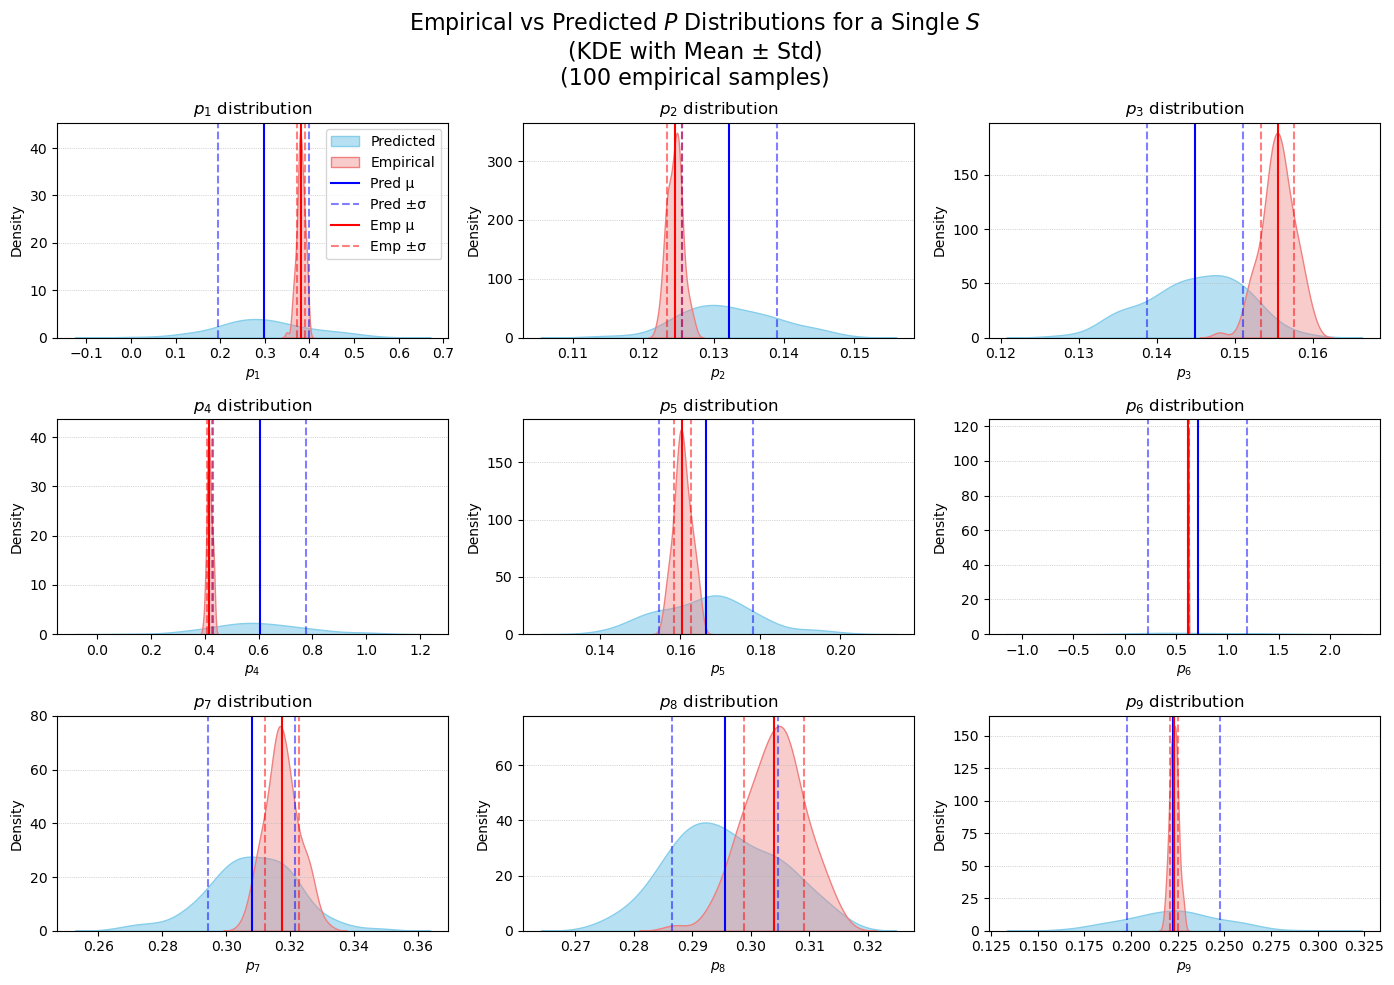


P      μ_emp   μ_pred    σ_emp   σ_pred      Δμ    σ*/σ       KL
-----------------------------------------------------------------
p1     0.380    0.297    0.009    0.103  -0.083   11.19    2.664
p2     0.124    0.132    0.001    0.007   0.008    6.17    1.780
p3     0.155    0.145    0.002    0.006  -0.011    2.88    6.173
p4     0.418    0.605    0.010    0.172   0.187   17.83    2.537
p5     0.161    0.167    0.002    0.012   0.006    5.46    1.640
p6     0.620    0.709    0.003    0.480   0.090  152.64    3.507
p7     0.318    0.308    0.005    0.014  -0.010    2.61    1.593
p8     0.304    0.296    0.005    0.009  -0.008    1.75    0.743
p9     0.223    0.223    0.002    0.025  -0.000   10.92    1.754
-----------------------------------------------------------------
AVG                                                        2.488


In [30]:
fig, axs = plt.subplots(3, 3, figsize=(14, 10))
axs = axs.flatten()

for i in range(9):
    pred = P_hats[:, i]
    true = P_true_samples[:, i]

    # Compute means and stds
    mu_pred, std_pred = np.mean(pred), np.std(pred)
    mu_true, std_true = np.mean(true), np.std(true)

    # Plot KDEs
    sns.kdeplot(pred, ax=axs[i], fill=True, color='skyblue', alpha=0.6, label='Predicted')
    sns.kdeplot(true, ax=axs[i], fill=True, color='lightcoral', alpha=0.4, label='Empirical')

    # Plot vertical lines: mean ± std
    axs[i].axvline(mu_pred, color='blue', linestyle='-', label='Pred μ')
    axs[i].axvline(mu_pred + std_pred, color='blue', linestyle='--', alpha=0.5, label='Pred ±σ')
    axs[i].axvline(mu_pred - std_pred, color='blue', linestyle='--', alpha=0.5)

    axs[i].axvline(mu_true, color='red', linestyle='-', label='Emp μ')
    axs[i].axvline(mu_true + std_true, color='red', linestyle='--', alpha=0.5, label='Emp ±σ')
    axs[i].axvline(mu_true - std_true, color='red', linestyle='--', alpha=0.5)

    # Axis styling
    axs[i].set_title(f"$p_{{{i+1}}}$ distribution")
    axs[i].set_xlabel(f"$p_{{{i+1}}}$")
    axs[i].set_ylabel("Density")
    axs[i].grid(True, axis='y', linestyle=':', linewidth=0.5)

    if i == 0:
        axs[i].legend()

fig.suptitle(f"Empirical vs Predicted $P$ Distributions for a Single $S$\n(KDE with Mean ± Std)\n({P_true_samples.shape[0]} empirical samples)", fontsize=16)
plt.tight_layout()
plt.show()

# === summary stats and KL divergence ===
print(f"\n{'P':<3} {'μ_emp':>8} {'μ_pred':>8} {'σ_emp':>8} {'σ_pred':>8} {'Δμ':>7} {'σ*/σ':>7} {'KL':>8}")
print("-" * 65)
kl_vals = []
for i in range(9):
    emp, pred = P_true_samples[:, i], P_hats[:, i]
    mu_emp, mu_pred_i = np.mean(emp), np.mean(pred)
    std_emp, std_pred = np.std(emp), np.std(pred)
    bins = np.histogram_bin_edges(np.concatenate([emp, pred]), bins=30)
    emp_hist, _ = np.histogram(emp, bins=bins, density=True)
    pred_hist, _ = np.histogram(pred, bins=bins, density=True)
    emp_hist += 1e-10
    pred_hist += 1e-10
    kl = entropy(emp_hist, pred_hist)
    kl_vals.append(kl)
    print(f"p{i+1:<2} {mu_emp:8.3f} {mu_pred_i:8.3f} {std_emp:8.3f} {std_pred:8.3f} {mu_pred_i - mu_emp:7.3f} {std_pred/std_emp if std_emp > 0 else float('inf'):7.2f} {kl:8.3f}")
print("-" * 65)
print(f"{'AVG':<3} {'':>8} {'':>8} {'':>8} {'':>8} {'':>7} {'':>7} {np.mean(kl_vals):8.3f}")
